In [1]:
import pandas as pd

df = pd.read_csv("selected_features_labeled_final.csv",sep="\t")

In [2]:
df.describe()

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM
count,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.00000,4530.000000,4530.000000,4530.000000,4530.000000
mean,36456.702428,1.803753,1.964459,1.798896,1.734879,2.313024,29.465121,58.50287,7.006843,1.479691,430.410596,0.500442
std,2960.043928,0.441433,0.259625,0.400870,0.441447,0.838220,13.323306,65.08107,2.726140,0.499643,218.839914,0.500055
min,31132.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.00000,1.000000,1.000000,192.000000,0.000000
25%,33853.250000,2.000000,2.000000,2.000000,1.000000,2.000000,15.000000,20.00000,6.000000,1.000000,231.000000,0.000000
50%,36503.000000,2.000000,2.000000,2.000000,2.000000,2.000000,33.000000,30.00000,7.000000,1.000000,367.000000,1.000000
75%,38988.750000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.00000,8.000000,2.000000,580.000000,1.000000
max,41472.000000,9.000000,9.000000,2.000000,2.000000,4.000000,71.000000,600.00000,99.000000,2.000000,1019.000000,1.000000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import optuna

# 1. Feature / Target
X = df.drop('PreDM', axis=1)
y = df['PreDM']

# 2. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Objective 
def objective(trial):
    
    reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True)
    
    # XGBoost 
    model = XGBClassifier(
        eval_metric="logloss",
        random_state=2,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    return scores.mean()

# 5. Optuna study 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 6. 
print("Best trial:")
print(f"  Value (Accuracy): {study.best_trial.value:.4f}")
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-04 20:29:17,663] A new study created in memory with name: no-name-12758373-6bc1-4bbd-aa2f-d99cf9a31b4d
[I 2025-04-04 20:29:18,304] Trial 0 finished with value: 0.8878587196467992 and parameters: {'reg_alpha': 0.0010769686431289117, 'reg_lambda': 0.00020287212154722334}. Best is trial 0 with value: 0.8878587196467992.
[I 2025-04-04 20:29:18,955] Trial 1 finished with value: 0.8907284768211919 and parameters: {'reg_alpha': 1.0255586233985525e-05, 'reg_lambda': 0.2551167234727985}. Best is trial 1 with value: 0.8907284768211919.
[I 2025-04-04 20:29:19,568] Trial 2 finished with value: 0.8913907284768212 and parameters: {'reg_alpha': 7.791944193390298e-05, 'reg_lambda': 3.2639799134830064e-05}. Best is trial 2 with value: 0.8913907284768212.
[I 2025-04-04 20:29:20,303] Trial 3 finished with value: 0.8496688741721854 and parameters: {'reg_alpha': 3.163065201949569, 'reg_lambda': 2.789924408676947}. Best is trial 2 with value: 0.8913907284768212.
[I 2025-04-04 20:29:20,970] Trial 

Best trial:
  Value (Accuracy): 0.8976
  Params:
    reg_alpha: 0.00611346852915474
    reg_lambda: 0.0014723862507971443


In [22]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  # XGBoost 추가

X = df.drop('PreDM', axis=1)
#LBDINSI >= 100, LBXAPB >= 110, LBXGH >= 5.5
y = df['PreDM']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=10,shuffle=True)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=1),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=40),
    'XGBoost_reg': XGBClassifier(eval_metric='logloss', random_state=2,reg_alpha=0.015243985126367762,reg_lambda=0.00037552039707253616)

}

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name} Accuracy: {cv_scores[name].mean()}")




Logistic Regression Accuracy: 0.6626931567328919
SVM Accuracy: 0.6933774834437086
Random Forest Accuracy: 0.8905077262693156
Decision Tree Accuracy: 0.8905077262693155
XGBoost Accuracy: 0.8863134657836644
XGBoost_reg Accuracy: 0.9044150110375277


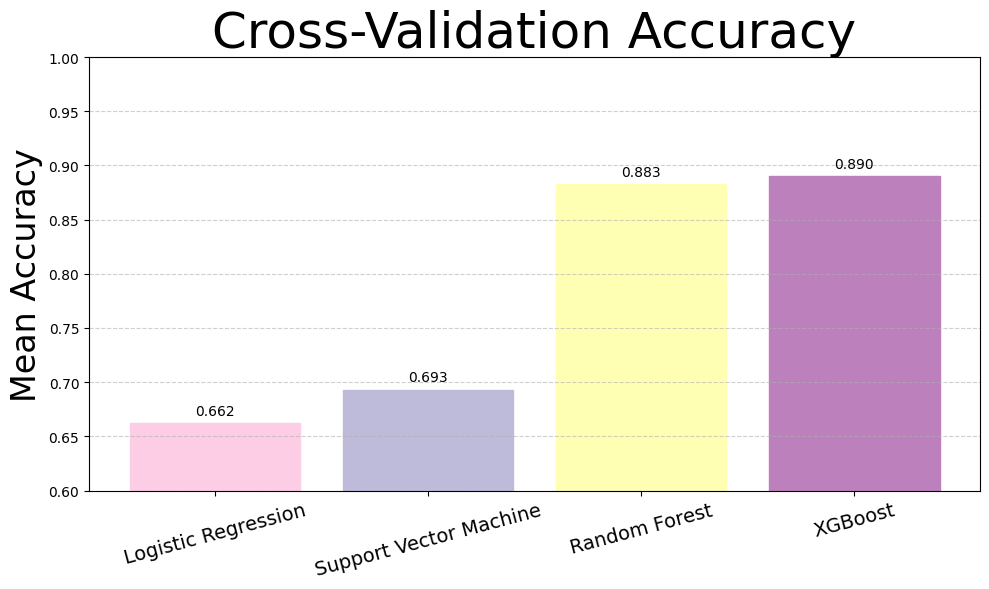

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Display name mapping
model_name_mapping = {
    'Logistic Regression': 'Logistic Regression',
    'SVM': 'Support Vector Machine',
    'Random Forest': 'Random Forest',
    'XGBoost': 'XGBoost'
}

# Select only the models you want to plot
selected_models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']

# Prepare display names and mean scores
model_names = [model_name_mapping[model] for model in selected_models]
mean_scores = [np.mean(cv_scores[model]) for model in selected_models]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mean_scores)

# Color the bars randomly from Set3
for bar in bars:
    bar.set_color(plt.cm.Set3(np.random.rand()))

# Annotate scores above bars
for i, score in enumerate(mean_scores):
    plt.text(i, score + 0.005, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0.6, 1.0)
plt.title("Cross-Validation Accuracy", fontsize=36)
plt.ylabel("Mean Accuracy", fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.xticks(rotation=15, fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Kannan\AppData\Local\Temp\ipykernel_6416\4053534082.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=labels)


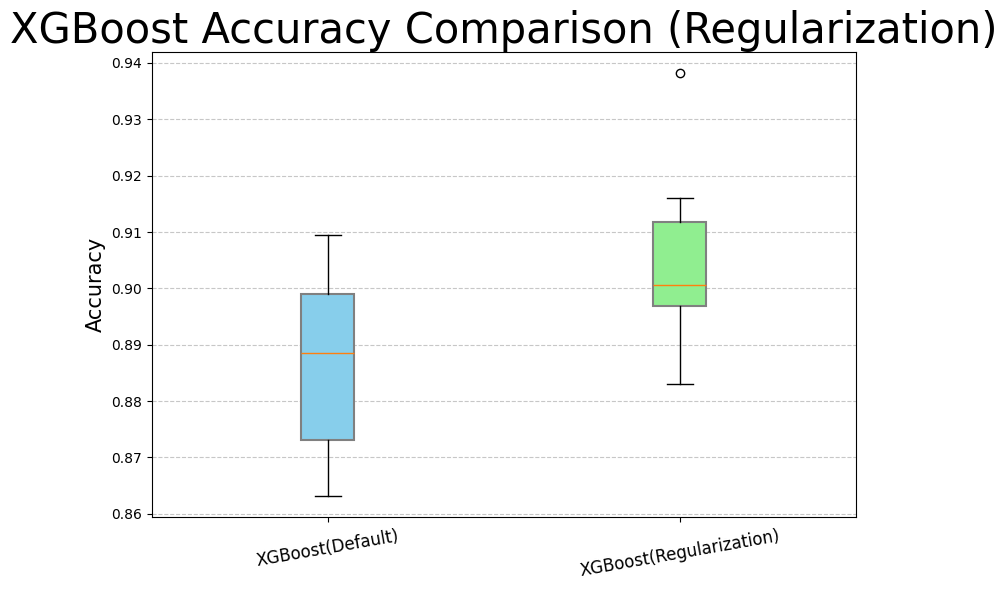

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


data = [cv_scores['XGBoost'], cv_scores['XGBoost_reg']]
labels = ['XGBoost(Default)', 'XGBoost(Regularization)']


plt.figure(figsize=(8, 6))


box = plt.boxplot(data, patch_artist=True, labels=labels)


colors = ['skyblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('gray')
    patch.set_linewidth(1.5)


plt.title('XGBoost Accuracy Comparison (Regularization)', fontsize=30)
plt.ylabel('Accuracy', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.xticks(rotation=10, fontsize=12)

plt.tight_layout()
plt.show()


 92%|==================  | 4182/4530 [00:12<00:00]       

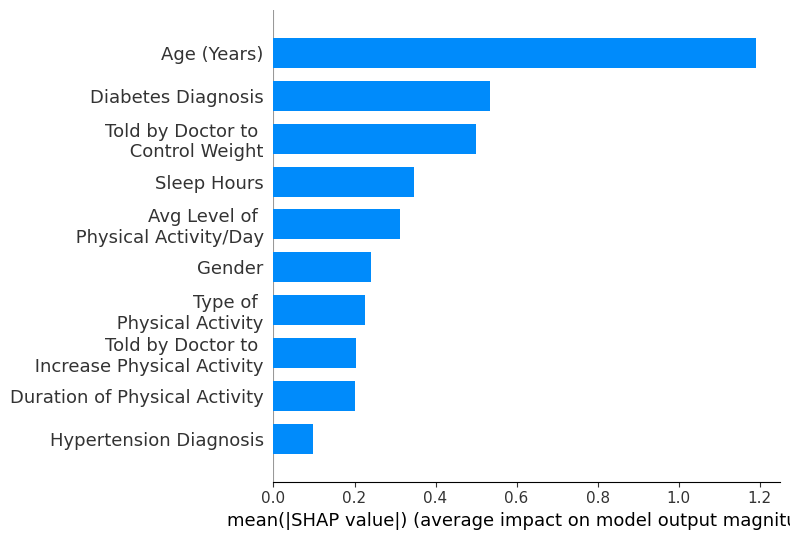

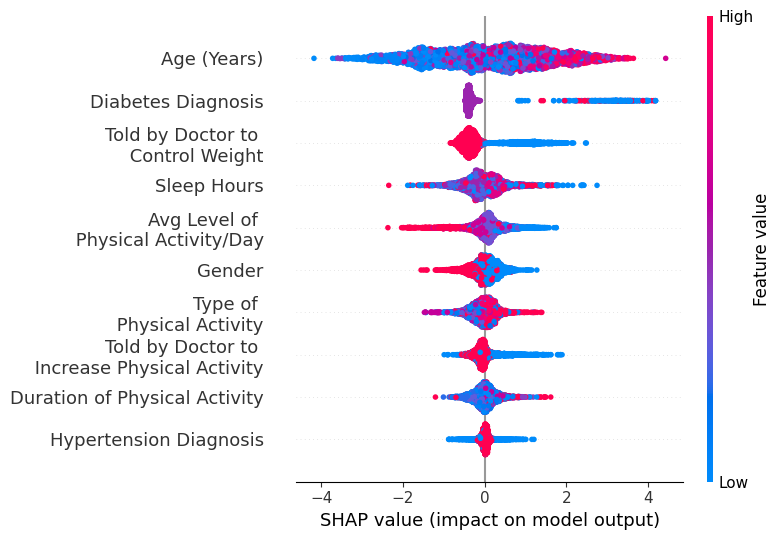

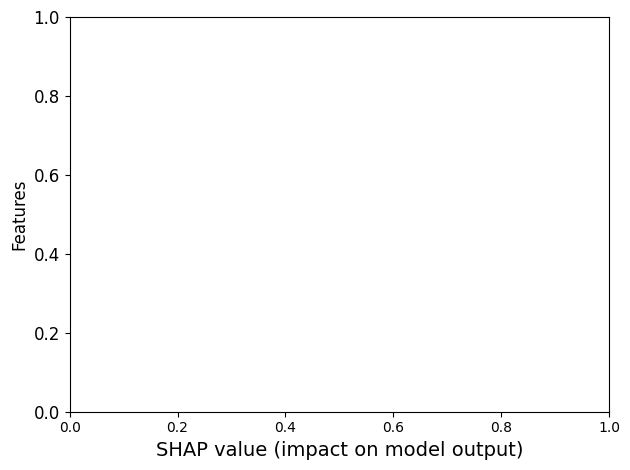

In [ ]:
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

feature_name_mapping = {
    'RIDAGEMN': 'Age (Years)',
    'DIQ010': 'Diabetes Diagnosis',
    'DIQ190A': 'Told by Doctor to \n Control Weight',
    'SLD010H': 'Sleep Hours',
    'PAQ180': 'Avg Level of \n Physical Activity/Day',
    'RIAGENDR': 'Gender',
    'PADACTIV': 'Type of \n Physical Activity',
    'DIQ190B': 'Told by Doctor to \n Increase Physical Activity',
    'PADDURAT': 'Duration of Physical Activity',
    'BPQ020': 'Hypertension Diagnosis',

}

# Rename the columns of the DataFrame
df_renamed = df.rename(columns=feature_name_mapping)

# 1. Feature / Target using the renamed DataFrame
X_renamed = df_renamed.drop(['SEQN','PreDM'], axis=1)
y = df_renamed['PreDM']

scaler = StandardScaler()
X_scaled_renamed = scaler.fit_transform(X_renamed)

# 2. XGBoost 
model = XGBClassifier(
    eval_metric='logloss',
    random_state=40,
    reg_alpha=0.028746265595634254,
    reg_lambda=0.020011163481365255
)
model.fit(X_scaled_renamed, y)

# 3. SHAP explainer 
explainer = shap.Explainer(model, X_scaled_renamed, feature_names=X_renamed.columns)
shap_values = explainer(X_scaled_renamed)

shap.summary_plot(shap_values, feature_names=X_renamed.columns, plot_type="bar")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=18)
plt.yticks(fontsize=25)
#plt.title("Feature Importance", fontsize=18) # Optional: Add a title with adjusted font size
plt.tight_layout() # Adjust layout to prevent labels from overlapping


shap.summary_plot(shap_values, feature_names=X_renamed.columns)
plt.xlabel("SHAP value (impact on model output)", fontsize=14)
plt.ylabel("Features", fontsize=12) # Add a y-axis label with adjusted font size
plt.yticks(fontsize=12)
#plt.title("SHAP Values per Feature", fontsize=16) # Optional: Add a title with adjusted font size
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# 4. SHAP summary plot
#shap.summary_plot(shap_values, feature_names=X_renamed.columns, plot_type="bar")  # feature importance bar plot
#shap.summary_plot(shap_values, feature_names=X_renamed.columns)  # dot plot (개별 샘플별 영향도 시각화)
